In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 14 16:02:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    14W / 230W |      8MiB / 23028MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = (torch.rand(M, k).cuda()*2-1) * prior_sigma
    mu = (torch.rand(N, k).cuda()*2-1) * post_sigma
            
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    alpha = -1/(2*elem_sigma**2)
    loss = -torch.mean(torch.logsumexp(alpha*distance, dim=1), dim=0)
    loss = loss + 0.5*k*(2*np.log(elem_sigma)-np.log(np.e)) + np.log(N)
    
    return loss.item()

from tqdm import tqdm

M = 1024
N = 256
k = 2
post_sigma = 1
elem_log_sigmas = np.arange(-10, 10, 0.01)

losses_list = []
for _ in tqdm(range(1000)):
    losses = np.array([get_kl(M, N, k, post_sigma, np.exp(elem_log_sigma)) for elem_log_sigma in elem_log_sigmas])
    losses_list.append(losses)
    
losses = np.median(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

100%|███████████████████████████████████████| 1000/1000 [10:26<00:00,  1.60it/s]

0.11765484302175948 -2.1400000000001675


In [5]:
losses = np.mean(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

0.11765484302175948 -2.1400000000001675


In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.init_log_sigma = -2.14
hp.h_dims = [32, 64, 128, 256, 512]

In [7]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [11]:
save_dir = '/data/scpark/save/lse/train01.14-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [13]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [14]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


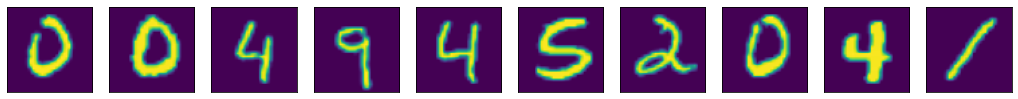

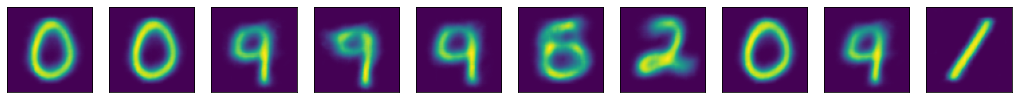

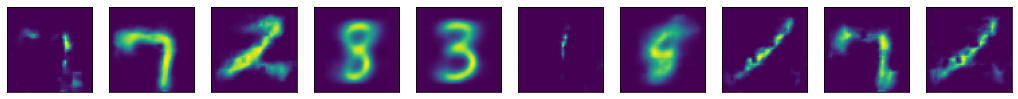

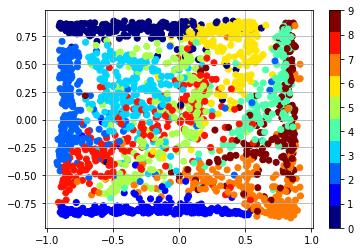

16001
lse_loss -1.5944807529449463
recon_loss 0.13615703582763672
16002
lse_loss -1.5869152545928955
recon_loss 0.13248014450073242
16003
lse_loss -1.574126124382019
recon_loss 0.12835060060024261
16004
lse_loss -1.5770187377929688
recon_loss 0.13517403602600098
16005
lse_loss -1.5869427919387817
recon_loss 0.12800297141075134
16006
lse_loss -1.5990920066833496
recon_loss 0.12314562499523163
16007
lse_loss -1.607098937034607
recon_loss 0.1382617950439453
16008
lse_loss -1.578994870185852
recon_loss 0.13129135966300964
16009
lse_loss -1.5791032314300537
recon_loss 0.12794601917266846
16010
lse_loss -1.6213204860687256
recon_loss 0.12906180322170258
16011
lse_loss -1.6013147830963135
recon_loss 0.13509303331375122
16012
lse_loss -1.6071958541870117
recon_loss 0.12869253754615784
16013
lse_loss -1.6077110767364502
recon_loss 0.12718476355075836
16014
lse_loss -1.5952411890029907
recon_loss 0.1289396733045578
16015
lse_loss -1.5596122741699219
recon_loss 0.12394405901432037
16016
lse_loss 

lse_loss -1.5824909210205078
recon_loss 0.13254523277282715
16129
lse_loss -1.5776352882385254
recon_loss 0.13802847266197205
16130
lse_loss -1.6151374578475952
recon_loss 0.13275589048862457
16131
lse_loss -1.6063934564590454
recon_loss 0.13301971554756165
16132
lse_loss -1.5884279012680054
recon_loss 0.13392719626426697
16133
lse_loss -1.5873754024505615
recon_loss 0.13530981540679932
16134
lse_loss -1.6051537990570068
recon_loss 0.12896952033042908
16135
lse_loss -1.6151244640350342
recon_loss 0.13320392370224
16136
lse_loss -1.6004741191864014
recon_loss 0.1268298327922821
16137
lse_loss -1.608882188796997
recon_loss 0.12951642274856567
16138
lse_loss -1.59949791431427
recon_loss 0.12819629907608032
16139
lse_loss -1.6119575500488281
recon_loss 0.13002878427505493
16140
lse_loss -1.5877490043640137
recon_loss 0.12649096548557281
16141
lse_loss -1.6022515296936035
recon_loss 0.1367984563112259
16142
lse_loss -1.5976457595825195
recon_loss 0.13022182881832123
16143
lse_loss -1.629562

16254
lse_loss -1.573333501815796
recon_loss 0.1268608570098877
16255
lse_loss -1.602943778038025
recon_loss 0.13202764093875885
16256
lse_loss -1.5727797746658325
recon_loss 0.13532404601573944
16257
lse_loss -1.5932493209838867
recon_loss 0.13392142951488495
16258
lse_loss -1.6012156009674072
recon_loss 0.13152644038200378
16259
lse_loss -1.5829381942749023
recon_loss 0.13311044871807098
16260
lse_loss -1.5580809116363525
recon_loss 0.13100795447826385
16261
lse_loss -1.5816805362701416
recon_loss 0.13359719514846802
16262
lse_loss -1.5896259546279907
recon_loss 0.1302960366010666
16263
lse_loss -1.5736749172210693
recon_loss 0.13063399493694305
16264
lse_loss -1.5987673997879028
recon_loss 0.12714239954948425
16265
lse_loss -1.5955226421356201
recon_loss 0.12913429737091064
16266
lse_loss -1.5447778701782227
recon_loss 0.12650097906589508
16267
lse_loss -1.5854878425598145
recon_loss 0.1326426863670349
16268
lse_loss -1.6037575006484985
recon_loss 0.12773826718330383
16269
lse_loss 

16380
lse_loss -1.6306695938110352
recon_loss 0.13765093684196472
16381
lse_loss -1.5923467874526978
recon_loss 0.12923568487167358
16382
lse_loss -1.5953736305236816
recon_loss 0.13068775832653046
16383
lse_loss -1.6002957820892334
recon_loss 0.12324845790863037
16384
lse_loss -1.5659958124160767
recon_loss 0.128435418009758
16385
lse_loss -1.603024959564209
recon_loss 0.1342805027961731
16386
lse_loss -1.5772433280944824
recon_loss 0.1277976781129837
16387
lse_loss -1.5962276458740234
recon_loss 0.12801089882850647
16388
lse_loss -1.5667226314544678
recon_loss 0.13021771609783173
16389
lse_loss -1.5909814834594727
recon_loss 0.12748543918132782
16390
lse_loss -1.5818655490875244
recon_loss 0.1237926036119461
16391
lse_loss -1.6011245250701904
recon_loss 0.1256210207939148
16392
lse_loss -1.5963987112045288
recon_loss 0.11986570060253143
16393
lse_loss -1.6003084182739258
recon_loss 0.13434642553329468
16394
lse_loss -1.5920140743255615
recon_loss 0.1315789818763733
16395
lse_loss -1.

16507
lse_loss -1.5682637691497803
recon_loss 0.13073885440826416
16508
lse_loss -1.6096017360687256
recon_loss 0.11829447746276855
16509
lse_loss -1.6099979877471924
recon_loss 0.12908689677715302
16510
lse_loss -1.6140530109405518
recon_loss 0.12959174811840057
16511
lse_loss -1.5970277786254883
recon_loss 0.12649010121822357
16512
lse_loss -1.5959277153015137
recon_loss 0.1242925375699997
16513
lse_loss -1.605712890625
recon_loss 0.12898144125938416
16514
lse_loss -1.598907232284546
recon_loss 0.12638208270072937
16515
lse_loss -1.5895633697509766
recon_loss 0.1275673806667328
16516
lse_loss -1.5757453441619873
recon_loss 0.12300211191177368
16517
lse_loss -1.5951354503631592
recon_loss 0.13085097074508667
16518
lse_loss -1.6160142421722412
recon_loss 0.13223007321357727
16519
lse_loss -1.5847301483154297
recon_loss 0.1269378513097763
16520
lse_loss -1.617348074913025
recon_loss 0.13482984900474548
16521
lse_loss -1.593116044998169
recon_loss 0.12665478885173798
16522
lse_loss -1.59

16633
lse_loss -1.548305630683899
recon_loss 0.13795915246009827
16634
lse_loss -1.5874133110046387
recon_loss 0.12864789366722107
16635
lse_loss -1.5905213356018066
recon_loss 0.12938019633293152
16636
lse_loss -1.5781077146530151
recon_loss 0.12326093763113022
16637
lse_loss -1.606269121170044
recon_loss 0.12979570031166077
16638
lse_loss -1.614283800125122
recon_loss 0.1266987919807434
16639
lse_loss -1.5479705333709717
recon_loss 0.13438081741333008
16640
lse_loss -1.5936295986175537
recon_loss 0.13298217952251434
16641
lse_loss -1.5950037240982056
recon_loss 0.13296061754226685
16642
lse_loss -1.5826983451843262
recon_loss 0.13025760650634766
16643
lse_loss -1.6112459897994995
recon_loss 0.12750451266765594
16644
lse_loss -1.6107836961746216
recon_loss 0.12603884935379028
16645
lse_loss -1.5496857166290283
recon_loss 0.13538621366024017
16646
lse_loss -1.6141386032104492
recon_loss 0.1288628876209259
16647
lse_loss -1.61958646774292
recon_loss 0.12918046116828918
16648
lse_loss -1

16761
lse_loss -1.5409371852874756
recon_loss 0.13590840995311737
16762
lse_loss -1.6195049285888672
recon_loss 0.13428474962711334
16763
lse_loss -1.5663156509399414
recon_loss 0.12555405497550964
16764
lse_loss -1.5720292329788208
recon_loss 0.12736991047859192
16765
lse_loss -1.5817360877990723
recon_loss 0.12680475413799286
16766
lse_loss -1.5927765369415283
recon_loss 0.1273762583732605
16767
lse_loss -1.6055976152420044
recon_loss 0.12707337737083435
16768
lse_loss -1.5742096900939941
recon_loss 0.12272493541240692
16769
lse_loss -1.581740140914917
recon_loss 0.13171064853668213
16770
lse_loss -1.584873080253601
recon_loss 0.13040229678153992
16771
lse_loss -1.622725009918213
recon_loss 0.1353032886981964
16772
lse_loss -1.5894920825958252
recon_loss 0.1256013810634613
16773
lse_loss -1.6232329607009888
recon_loss 0.1340017318725586
16774
lse_loss -1.5701870918273926
recon_loss 0.13005918264389038
16775
lse_loss -1.612889051437378
recon_loss 0.12728498876094818
16776
lse_loss -1.

16889
lse_loss -1.598233699798584
recon_loss 0.13760603964328766
16890
lse_loss -1.6019840240478516
recon_loss 0.12193696200847626
16891
lse_loss -1.607741117477417
recon_loss 0.1274804174900055
16892
lse_loss -1.573106050491333
recon_loss 0.12381130456924438
16893
lse_loss -1.590254783630371
recon_loss 0.12943288683891296
16894
lse_loss -1.5651086568832397
recon_loss 0.12471114099025726
16895
lse_loss -1.5979986190795898
recon_loss 0.12154842913150787
16896
lse_loss -1.5998620986938477
recon_loss 0.12003876268863678
16897
lse_loss -1.5852569341659546
recon_loss 0.130194753408432
16898
lse_loss -1.5983633995056152
recon_loss 0.12746497988700867
16899
lse_loss -1.5828206539154053
recon_loss 0.12690597772598267
16900
lse_loss -1.5716986656188965
recon_loss 0.1257401555776596
16901
lse_loss -1.5807439088821411
recon_loss 0.12139301002025604
16902
lse_loss -1.5877127647399902
recon_loss 0.12223686277866364
16903
lse_loss -1.6064352989196777
recon_loss 0.12570098042488098
16904
lse_loss -1.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1024, sigma=np.exp(hp.init_log_sigma))
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024, sigma=np.exp(hp.init_log_sigma))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        